<a href="https://colab.research.google.com/github/shinyumi43/deep-learning/blob/main/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools, os, argparse
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# 학습률
learning_rate = 0.001 

# 전체 train set에 대해 forward 및 backward step을 진행할 횟수
training_epochs = 15 

# 학습할 때 몇 개의 데이터를 넣을지 결정
batch_size = 100 

In [ ]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

In [ ]:
# 훈련 및 테스트 데이터의 개수
print("Number of training data : ", len(mnist_train))
print("Number of test data : ", len(mnist_test))

Number of training data :  60000
Number of test data :  10000


type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])
type of label :  <class 'int'>
label :  5


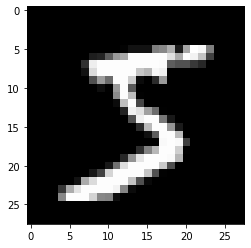

In [ ]:
import torchvision
import matplotlib.pyplot as plt

# 훈련 데이터 중 하나만 출력
one_image, label = mnist_train[0]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)

In [ ]:
# 데이터를 불러올 때 사용, 데이터 로더를 사용하여 배치 크기 지정
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [ ]:
# 원본 이미지와 필터를 갖고, convolution 연산을 수행해 중요한 feature를 detect한 후, maxpooling이라는 압축 과정을 거쳐 또 한번 중요한 feature만을 남기는 과정
class CNN(torch.nn.Module):

    # 네트워크에서 사용할 모듈들을 초기화
    def __init__(self):
        # nn.module 상속
        super(CNN, self).__init__()
        
        # kernal_size : 입력된 이미지에 대해 얼만큼의 시야를 갖는지를 결정
        # stride : 이미지를 횡단할 때, kernal의 step size를 결정
        # padding : convolution 연산을 수행할 샘플의 테두리를 어떻게 처리할지를 결정

        # 합성곱(nn.Conv2d) + 활성화 함수(nn.ReLU) + 맥스풀링(nn.MaxPool2d)가 하나의 층
        # 첫번째층
        self.layer1 = torch.nn.Sequential(
            # 1채널의 이미지를 입력받아서 32채널을 뽑아내는데, 커널 사이즈는 3x3
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            # 활성화 함수
            torch.nn.ReLU(),
            # 맥스풀링을 통해 2x2로 압축
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    #모델 네트워크 레이어 쌓기
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # 첫번째 차원인 배치 차원은 그대로 두고, 나머지 펼치기   
        out = self.fc(out)
        return out

In [ ]:
# CNN 모델 정의
model = CNN().to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 상황과 데이터에 따라 종류와 파라미터를 바꾸어 가며 실험해 보아야 하는 hyperparameter

In [ ]:
# 배치 크기가 100, 총 배치의 수는 600이므로 훈련 데이터는 총 60000개
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


In [ ]:
# 모델 훈련
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad() #그래디언트를 0으로 초기화(backward()를 호출할 때마다 그래디언트를 누적하므로 해당 과정이 반드시 필요)
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward() # 모델의 매개 변수에 대한 gradient를 계산
        optimizer.step() # 매개 변수 갱신, 학습이 수행되는 한 step을 의미

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch:    1] cost = 0.225630581
[Epoch:    2] cost = 0.0629239455
[Epoch:    3] cost = 0.0462388545
[Epoch:    4] cost = 0.0373307504
[Epoch:    5] cost = 0.0314979367
[Epoch:    6] cost = 0.0259948764
[Epoch:    7] cost = 0.0217639506
[Epoch:    8] cost = 0.0184227545
[Epoch:    9] cost = 0.016512271
[Epoch:   10] cost = 0.0132639883
[Epoch:   11] cost = 0.0101903267
[Epoch:   12] cost = 0.00979960803
[Epoch:   13] cost = 0.00848219264
[Epoch:   14] cost = 0.00675378554
[Epoch:   15] cost = 0.00651646592


In [ ]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    # 정확도 측정
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.988099992275238


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
